In [1]:
library(dplyr)

# Load necessary libraries
library(ggplot2)
library(gridExtra)


Warning message:
"package 'dplyr' was built under R version 4.3.2"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'ggplot2' was built under R version 4.3.3"

Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




In [2]:
library(xgboost) 
library(ParBayesianOptimization)

Warning message:
"package 'xgboost' was built under R version 4.3.3"

Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice


Warning message:
"package 'ParBayesianOptimization' was built under R version 4.3.3"


In [3]:
options(scipen = 999)

In [4]:
library(doParallel)
library(foreach)

Warning message:
"package 'doParallel' was built under R version 4.3.3"
Loading required package: foreach

Warning message:
"package 'foreach' was built under R version 4.3.3"
Loading required package: iterators

Warning message:
"package 'iterators' was built under R version 4.3.3"
Loading required package: parallel



In [5]:
# Load the test dataset
test_path <- "C:\\all_programming\\Kaggle\\datasets\\test\\test.csv"
test <- read.csv(test_path, stringsAsFactors = FALSE)
dim(test)   # has empty fields

train_path <- "C:\\all_programming\\Kaggle\\datasets\\train\\train.csv"
train <- read.csv(train_path, stringsAsFactors = FALSE)
dim(train)

[1] 800000     20

[1] 1200000      21

In [6]:
head(train, 2)

,id,Age,Gender,Annual.Income,Marital.Status,Number.of.Dependents,Education.Level,Occupation,Health.Score,Location,⋯,Previous.Claims,Vehicle.Age,Credit.Score,Insurance.Duration,Policy.Start.Date,Customer.Feedback,Smoking.Status,Exercise.Frequency,Property.Type,Premium.Amount
,<int>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,0,19,Female,10049,Married,1,Bachelor's,Self-Employed,22.59876,Urban,⋯,2,17,372,5,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869
2,1,39,Female,31678,Divorced,3,Master's,,15.56973,Rural,⋯,1,12,694,2,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483


In [7]:
sum(is.na(train))
sum(is.na(test))
sum(is.null(train))
sum(is.null(test))

[1] 749320

[1] 499186

[1] 0

[1] 0

In [8]:
ct_na <- function(x) { sum(is.na(x)) }
all_nas <- lapply(train, ct_na)
all_nas

$id
[1] 0

$Age
[1] 18705

$Gender
[1] 0

$Annual.Income
[1] 44949

$Marital.Status
[1] 0

$Number.of.Dependents
[1] 109672

$Education.Level
[1] 0

$Occupation
[1] 0

$Health.Score
[1] 74076

$Location
[1] 0

$Policy.Type
[1] 0

$Previous.Claims
[1] 364029

$Vehicle.Age
[1] 6

$Credit.Score
[1] 137882

$Insurance.Duration
[1] 1

$Policy.Start.Date
[1] 0

$Customer.Feedback
[1] 0

$Smoking.Status
[1] 0

$Exercise.Frequency
[1] 0

$Property.Type
[1] 0

$Premium.Amount
[1] 0

In [9]:
is.character(train$Gender)
getChar <- function (x) { is.character(x) }
logis_char <- sapply(train, getChar)
df_char <- train[, logis_char]
dim(df_char)
head(df_char, 3)

[1] TRUE

[1] 1200000      11

,Gender,Marital.Status,Education.Level,Occupation,Location,Policy.Type,Policy.Start.Date,Customer.Feedback,Smoking.Status,Exercise.Frequency,Property.Type
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Female,Married,Bachelor's,Self-Employed,Urban,Premium,2023-12-23 15:21:39.134960,Poor,No,Weekly,House
2,Female,Divorced,Master's,,Rural,Comprehensive,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House
3,Male,Divorced,High School,Self-Employed,Suburban,Premium,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House


In [10]:
# Fill missing values in numeric columns
numeric_columns <- names(select_if(train, is.numeric))

for (col in numeric_columns) {
  if (col %in% names(test)) {
    median_value <- median(train[[col]], na.rm = TRUE)
    train[[col]][is.na(train[[col]])] <- median_value
    test[[col]][is.na(test[[col]])] <- median_value
  }
}


In [11]:
# Fill missing values in categorical columns
categorical_columns <- names(select_if(train, is.character))

for (col in categorical_columns) {
  if (col %in% names(test)) {
    train[[col]][is.na(train[[col]]) | train[[col]] == ""] <- "Unknown" 
    test[[col]][is.na(test[[col]]) | test[[col]] == ""] <- "Unknown" 
  }
}


In [12]:
head(train, 3)

,id,Age,Gender,Annual.Income,Marital.Status,Number.of.Dependents,Education.Level,Occupation,Health.Score,Location,⋯,Previous.Claims,Vehicle.Age,Credit.Score,Insurance.Duration,Policy.Start.Date,Customer.Feedback,Smoking.Status,Exercise.Frequency,Property.Type,Premium.Amount
,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,0,19,Female,10049,Married,1,Bachelor's,Self-Employed,22.59876,Urban,⋯,2,17,372,5,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869
2,1,39,Female,31678,Divorced,3,Master's,Unknown,15.56973,Rural,⋯,1,12,694,2,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483
3,2,23,Male,25602,Divorced,3,High School,Self-Employed,47.17755,Suburban,⋯,1,14,595,3,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567


In [13]:
sum(is.na(train))
sum(is.na(test))

[1] 0

[1] 0

In [14]:
# Fill missing values in numeric columns
numeric_columns <- names(select_if(train, is.numeric))

for (col in numeric_columns) {
  if (col %in% names(test)) {
    median_value <- median(train[[col]], na.rm = TRUE)
    train[[col]][is.na(train[[col]])] <- median_value
    test[[col]][is.na(test[[col]])] <- median_value
  }
}

# Fill missing values and empty strings in categorical columns
categorical_columns <- names(select_if(train, is.character))

for (col in categorical_columns) {
  if (col %in% names(test)) {
    # Handle missing and empty values
    train[[col]][is.na(train[[col]]) | train[[col]] == ""] <- "Unknown"
    test[[col]][is.na(test[[col]]) | test[[col]] == ""] <- "Unknown"
    
    # Encode as factors to numerical
    levels_train <- unique(train[[col]])
    train[[col]] <- as.integer(factor(train[[col]], levels = levels_train))
    test[[col]] <- as.integer(factor(test[[col]], levels = levels_train))
  }
}

# View the updated data
head(train)
head(test)


,id,Age,Gender,Annual.Income,Marital.Status,Number.of.Dependents,Education.Level,Occupation,Health.Score,Location,⋯,Previous.Claims,Vehicle.Age,Credit.Score,Insurance.Duration,Policy.Start.Date,Customer.Feedback,Smoking.Status,Exercise.Frequency,Property.Type,Premium.Amount
,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>
1,0,19,1,10049,1,1,1,1,22.59876,1,⋯,2,17,372,5,1,1,1,1,1,2869
2,1,39,1,31678,2,3,2,2,15.56973,2,⋯,1,12,694,2,2,2,2,2,1,1483
3,2,23,2,25602,2,3,3,1,47.17755,3,⋯,1,14,595,3,3,3,2,1,1,567
4,3,21,2,141855,1,2,1,2,10.93814,2,⋯,1,0,367,1,4,1,2,3,2,765
5,4,21,2,39651,3,1,1,1,20.37609,2,⋯,0,8,598,4,5,1,2,1,1,2022
6,5,29,2,45963,1,1,1,2,33.05320,1,⋯,2,4,614,5,6,2,1,1,1,3202


,id,Age,Gender,Annual.Income,Marital.Status,Number.of.Dependents,Education.Level,Occupation,Health.Score,Location,Policy.Type,Previous.Claims,Vehicle.Age,Credit.Score,Insurance.Duration,Policy.Start.Date,Customer.Feedback,Smoking.Status,Exercise.Frequency,Property.Type
,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,1200000,28,1,2310,4,4,1,1,7.657981,2,3,1,19,595,1,91114,1,2,1,1
2,1200001,31,1,126031,1,2,2,1,13.381379,3,1,1,14,372,8,138963,3,2,4,2
3,1200002,47,1,17092,2,0,4,4,24.354527,1,2,1,16,819,9,19985,2,2,2,3
4,1200003,28,1,30424,2,3,4,1,5.136225,3,2,1,3,770,5,6016,1,2,3,1
5,1200004,24,2,10863,2,2,3,4,11.844155,3,1,1,14,755,7,68087,2,1,1,1
6,1200005,43,2,52370,1,2,1,2,5.386224,3,3,1,15,432,2,25226,4,1,4,3


In [15]:
# Exclude target column
target_column <- "Premium.Amount"
numerical_columns <- setdiff(names(select_if(train, is.numeric)), target_column)


In [16]:
# Apply normalization using scale()
train_scaled <- scale(train[numerical_columns])
test_scaled <- scale(test[numerical_columns], center = attr(train_scaled, "scaled:center"), scale = attr(train_scaled, "scaled:scale"))

# Convert scaled matrices back to dataframes
train[numerical_columns] <- as.data.frame(train_scaled)
test[numerical_columns] <- as.data.frame(test_scaled)

# View the updated data
head(train)
head(test)


,id,Age,Gender,Annual.Income,Marital.Status,Number.of.Dependents,Education.Level,Occupation,Health.Score,Location,⋯,Previous.Claims,Vehicle.Age,Credit.Score,Insurance.Duration,Policy.Start.Date,Customer.Feedback,Smoking.Status,Exercise.Frequency,Property.Type,Premium.Amount
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.732049,-1.6482999,-1.0042938,-0.70741367,-1.21693937,-0.746861392,-1.3306379,-1.3446842,-0.2496095,-1.229596877,⋯,1.216738815,1.2863374,-1.56737412,-0.007022686,-1.290008,-1.2091332,-1.0031261,-1.3272385,-1.22403788,2869
2,-1.732046,-0.1595423,-1.0042938,-0.02328945,-0.03748026,0.733499897,-0.4401924,-0.4242797,-0.8441097,-0.004116593,⋯,-0.002283635,0.4207126,0.71462973,-1.163390495,-1.289985,-0.1334581,0.9968828,-0.4360916,-1.22403788,1483
3,-1.732043,-1.3505484,0.9957237,-0.21547304,-0.03748026,0.733499897,0.4502530,-1.3446842,1.8292114,1.221363692,⋯,-0.002283635,0.7669625,0.01301985,-0.777934559,-1.289963,0.9422170,0.9968828,-1.3272385,-1.22403788,567
4,-1.732040,-1.4994241,0.9957237,3.46160370,-1.21693937,-0.006680747,-1.3306379,-0.4242797,-1.2358393,-0.004116593,⋯,-0.002283635,-1.6567871,-1.60280896,-1.548846431,-1.289941,-1.2091332,0.9968828,0.4550552,0.00068993,765
5,-1.732037,-1.4994241,0.9957237,0.22889615,1.14197885,-0.746861392,-1.3306379,-1.3446842,-0.4375979,-0.004116593,⋯,-1.221306086,-0.2717873,0.03428076,-0.392478622,-1.289919,-1.2091332,0.9968828,-1.3272385,-1.22403788,2022
6,-1.732034,-0.9039211,0.9957237,0.42854440,-1.21693937,-0.746861392,-1.3306379,-0.4242797,0.6346042,-1.229596877,⋯,1.216738815,-0.9642872,0.14767225,-0.007022686,-1.289896,-0.1334581,-1.0031261,-1.3272385,-1.22403788,3202


,id,Age,Gender,Annual.Income,Marital.Status,Number.of.Dependents,Education.Level,Occupation,Health.Score,Location,Policy.Type,Previous.Claims,Vehicle.Age,Credit.Score,Insurance.Duration,Policy.Start.Date,Customer.Feedback,Smoking.Status,Exercise.Frequency,Property.Type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.732052,-0.9783590,-1.0042938,-0.95219786,2.32143795,1.473680542,-1.3306379,-1.3446842,-1.5132685,-0.004116593,1.227804259,-0.002283635,1.6325874,0.01301985,-1.548846431,0.7359770,-1.2091332,0.9968828,-1.3272385,-1.22403788
2,1.732054,-0.7550453,-1.0042938,2.96109135,-1.21693937,-0.006680747,-0.4401924,-1.3446842,-1.0291958,1.221363692,-1.221086136,-0.002283635,0.7669625,-1.56737412,1.149345123,1.7999452,0.9422170,0.9968828,1.3462021,0.00068993
3,1.732057,0.4359608,-1.0042938,-0.48464392,-0.03748026,-1.487042036,1.3406984,1.4165295,-0.1011106,-1.229596877,0.003359061,-0.002283635,1.1132125,1.60050079,1.534801059,-0.8456443,-0.1334581,0.9968828,-0.4360916,1.22541774
4,1.732060,-0.9783590,-1.0042938,-0.06295341,-0.03748026,0.733499897,1.3406984,-1.3446842,-1.7265531,1.221363692,0.003359061,-0.002283635,-1.1374121,1.25323934,-0.007022686,-1.1562583,-1.2091332,0.9968828,0.4550552,-1.22403788
5,1.732063,-1.2761105,0.9957237,-0.68166689,-0.03748026,-0.006680747,0.4502530,1.4165295,-1.1592109,1.221363692,-1.221086136,-0.002283635,0.7669625,1.14693481,0.763889187,0.2239496,-0.1334581,-1.0031261,-1.3272385,-1.22403788
6,1.732066,0.1382092,0.9957237,0.63119750,-1.21693937,-0.006680747,-1.3306379,-0.4242797,-1.7054088,1.221363692,1.227804259,-0.002283635,0.9400875,-1.14215601,-1.163390495,-0.7291056,2.0178921,-1.0031261,1.3462021,1.22541774


In [17]:
# Function to create individual histograms
create_histogram <- function(data, column_name) {
  ggplot(data, aes_string(x = column_name)) +
    geom_histogram(bins = 20, fill = 'skyblue', color = 'black', lwd = 0.5) +
    ggtitle(column_name) +
    theme_minimal() +
    theme(plot.title = element_text(size = 9),
          axis.title = element_blank(),
          axis.text = element_text(size = 6))
}

# Create a list of plots
plots <- lapply(names(train), function(column) create_histogram(train, column))


Warning message:
"`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more
  information."


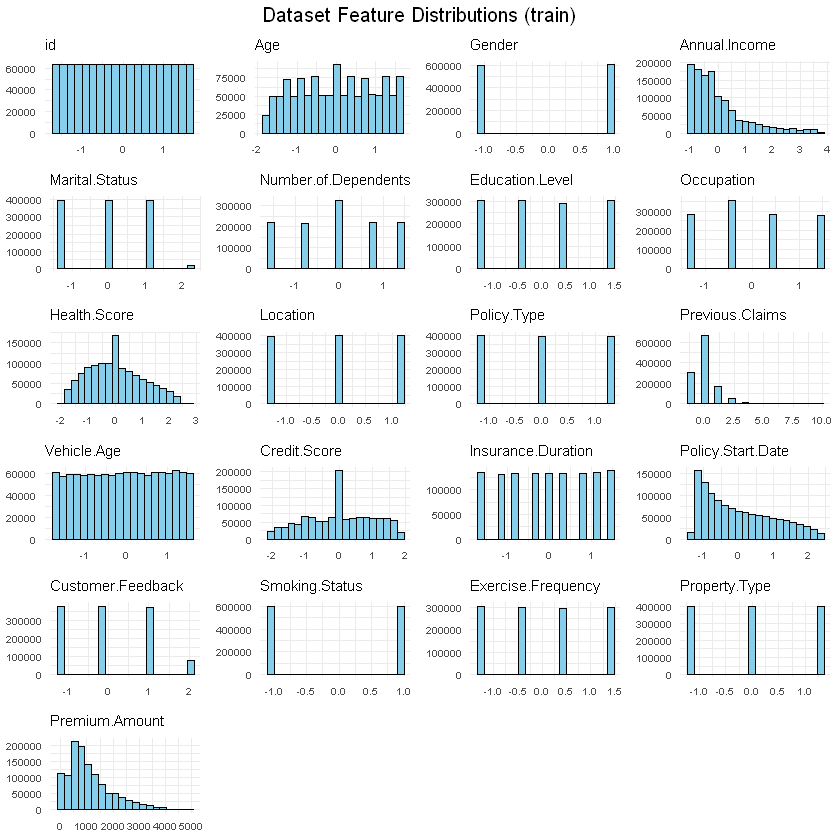

In [18]:
# Arrange plots in a grid layout
grid.arrange(grobs = plots, ncol = 4, top = "Dataset Feature Distributions (train)")


In [19]:
stopper

ERROR: Error: object 'stopper' not found


In [ ]:
# Prepare training data
X_train <- train %>% select(-one_of(target_column))
y_train <- train[[target_column]]
y_train_log <- log1p(y_train)  # Apply log transformation


In [ ]:
# Display data types
print(sapply(X_train, class))
print(class(y_train))
print(class(y_train_log))


In [ ]:
# Register parallel backend
cl <- makeCluster(detectCores() - 1)
registerDoParallel(cl)


In [ ]:
# Check each parameter individually
test_params <- list(
  nrounds = 50,
  max_depth = 5,
  eta = 0.1,
  gamma = 0.1,
  colsample_bytree = 0.5,
  min_child_weight = 1
)

params <- list(
  booster = "gbtree",
  objective = "reg:squarederror",
  max_depth = test_params$max_depth,
  eta = test_params$eta,
  gamma = test_params$gamma,
  colsample_bytree = test_params$colsample_bytree,
  min_child_weight = test_params$min_child_weight
)

cv <- xgb.cv(
  params = params,
  data = X_train,
  label = y_train_log,
  nrounds = test_params$nrounds,
  nfold = 5,
  verbose = 1,
  early_stopping_rounds = 10,
  metrics = "rmse"
)

print(cv)


### Change the date char var to date type 

In [ ]:
# Convert Date variable to date-time format
train$Policy.Start.Date <- as.Date(train$Policy.Start.Date, format="%Y-%m-%d")

# Check the structure of the dataframe to confirm the conversion
str(train$Policy.Start.Date)


### The structure of ALL numeric looks good here.

In [ ]:
# Assuming `train` has been converted to date format
str(train)  # Confirm the date conversion

# # Prepare training data
# X_train <- train %>% select(-one_of(target_column))
# y_train <- train[[target_column]]
# y_train_log <- log1p(y_train)

# X_train <- as.matrix(X_train)  # Convert to matrix

# # Ensure no missing values
# sum(is.na(X_train))
# sum(is.na(y_train_log))


In [ ]:
# Check the structure and summary of the data
str(X_train)
summary(X_train)
sum(is.na(X_train))
sum(is.na(y_train_log))



### Do NOT want catagorical vars ... aka factors

In [ ]:
# Sample code to convert character columns to factors (categorical)
# categorical_columns <- c("Gender", "Marital.Status", "Education.Level", "Occupation", 
#                          "Location", "Policy.Type", "Previous.Claims", "Customer.Feedback", 
#                          "Smoking.Status", "Exercise.Frequency", "Property.Type")
# for (col in categorical_columns) {
#   train[[col]] <- as.factor(train[[col]])
# }

# # Verify the conversion
# str(train)


In [ ]:
# Assuming Policy.Start.Date is already in date format, but let's ensure it
train$Policy.Start.Date <- as.Date(train$Policy.Start.Date, format="%Y-%m-%d")

# Verify the conversion
str(train)


In [ ]:
# Ensure data is in numeric and factor format as required
str(train)

# Prepare training data
X_train <- train %>% select(-one_of("Premium.Amount"))
y_train <- train$Premium.Amount
y_train_log <- log1p(y_train)

# Convert X_train to matrix for xgboost
X_train <- as.matrix(X_train)


    It seems the issue is that the data being passed to xgb.cv is of class 'character', but it needs to be either a numeric matrix or a single filename. This indicates that the data conversion wasn't successful for some columns. Let's address this by ensuring that all the numeric columns in your data are properly converted to numeric types before passing them to xgb.cv.

In [ ]:
# Convert factor columns to numeric
factor_columns <- c("Gender", "Marital.Status", "Education.Level", "Occupation", 
                    "Location", "Policy.Type", "Previous.Claims", "Customer.Feedback", 
                    "Smoking.Status", "Exercise.Frequency", "Property.Type")

for (col in factor_columns) {
  train[[col]] <- as.numeric(as.factor(train[[col]]))
}

# Check the structure again to confirm conversion
str(train)


In [ ]:
# Prepare training data
X_train <- train %>% select(-one_of("Premium.Amount"))
y_train <- train$Premium.Amount
y_train_log <- log1p(y_train)

# Convert X_train to matrix
X_train <- as.matrix(X_train)

# Ensure no missing values
sum(is.na(X_train))
sum(is.na(y_train_log))

# Check data types
str(X_train)
str(y_train_log)


In [ ]:
# Direct test of the simplified objective function
test_result <- objective_function_test(nrounds = 50, max_depth = 5, eta = 0.1)
print(test_result)


## Jump Start

In [ ]:
dim(train)
names(train[16])
train <- train[,-16]
dim(train)

In [ ]:
colnames(train)


In [ ]:
str(train)

In [ ]:
# Function to convert relevant columns to numeric
convert_to_numeric <- function(df) {
  df[] <- lapply(df, function(x) {
    if(is.factor(x) || is.character(x)) {
      as.numeric(as.character(x))
    } else {
      x
    }
  })
  return(df)
}

In [ ]:
# Apply the conversion function to your training data
X_train <- convert_to_numeric(train %>% select(-one_of("Premium.Amount")))

# Check the structure to confirm conversion
str(X_train)

In [ ]:
# Prepare training data
y_train <- train$Premium.Amount
y_train_log <- log1p(y_train)

# Convert X_train to numeric matrix
X_train <- as.matrix(X_train)

# Ensure no missing values
sum(is.na(X_train))
sum(is.na(y_train_log))

# Check data types
str(X_train)
str(y_train_log)


In [ ]:
# Simplified objective function test
test_result <- objective_function_test(nrounds = 50, max_depth = 5, eta = 0.1)
print(test_result)


In [ ]:
stopper

In [ ]:
# Extract column names separately
col_names <- colnames(X_train)

# Convert data to numeric while ensuring column names remain character strings
X_train <- apply(X_train, 2, function(x) as.numeric(as.character(x)))

# Re-assign column names to the numeric matrix
colnames(X_train) <- col_names

# Verify the structure to confirm conversion
str(X_train)


In [ ]:
# Prepare training data
y_train <- train$Premium.Amount
y_train_log <- log1p(y_train)

# Ensure X_train is a numeric matrix
X_train <- as.matrix(X_train)

# Ensure no missing values
sum(is.na(X_train))
sum(is.na(y_train_log))

# Check data types
str(X_train)
str(y_train_log)


In [ ]:
# Simplified objective function test
test_result <- objective_function_test(nrounds = 50, max_depth = 5, eta = 0.1)
print(test_result)


In [ ]:
# Simplified objective function for testing
objective_function_test <- function(nrounds, max_depth, eta) {
  cat("Testing Parameters:\n")
  cat("nrounds:", nrounds, "max_depth:", max_depth, "eta:", eta, "\n")
  
  params <- list(
    booster = "gbtree",
    objective = "reg:squarederror",
    max_depth = max_depth,
    eta = eta
  )
  
  tryCatch({
    cv <- xgb.cv(
      params = params,
      data = X_train,
      label = y_train_log,
      nrounds = nrounds,
      nfold = 5,
      verbose = 0,
      early_stopping_rounds = 10,
      metrics = "rmse"
    )
    score <- -min(cv$evaluation_log$test_rmse_mean)
    cat("Score:", score, "\n")
    list(Score = score, nrounds = nrounds, max_depth = max_depth, eta = eta)
  }, error = function(e) {
    cat("Error in xgb.cv: ", e$message, "\n")
    traceback()
    list(Score = NA, nrounds = nrounds, max_depth = max_depth, eta = eta)
  })
}

# Simplified bounds for testing
bounds_test <- list(
  nrounds = c(10L, 50L),
  max_depth = c(3L, 6L),
  eta = c(0.01, 0.1)
)

# Run Bayesian Optimization with the simplified function
opt_results_test <- bayesOpt(
  FUN = objective_function_test,
  bounds = bounds_test,
  initPoints = 5,
  iters.n = 10,
  verbose = 1,
  parallel = FALSE  # Disable parallel processing for debugging
)

# Display the best parameters and score
head(opt_results_test$Best_Par)
head(opt_results_test$Best_Value)


In [ ]:
# Identify duplicated column names in scoreSummary
duplicated_columns <- names(scoreSummary)[duplicated(names(scoreSummary))]
print(duplicated_columns)


In [ ]:
# Simplified objective function for testing
objective_function_test <- function(nrounds, max_depth, eta) {
  cat("Testing Parameters:\n")
  cat("nrounds:", nrounds, "max_depth:", max_depth, "eta:", eta, "\n")
  
  params <- list(
    booster = "gbtree",
    objective = "reg:squarederror",
    max_depth = max_depth,
    eta = eta
  )
  
  tryCatch({
    cv <- xgb.cv(
      params = params,
      data = X_train,
      label = y_train_log,
      nrounds = nrounds,
      nfold = 5,
      verbose = 0,
      early_stopping_rounds = 10,
      metrics = "rmse"
    )
    score <- -min(cv$evaluation_log$test_rmse_mean)
    cat("Score:", score, "\n")
    list(Score = score, nrounds = nrounds, max_depth = max_depth, eta = eta)
  }, error = function(e) {
    cat("Error in xgb.cv: ", e$message, "\n")
    traceback()
    list(Score = NA, nrounds = nrounds, max_depth = max_depth, eta = eta)
  })
}

# Define the bounds for the simplified search space
bounds_test <- list(
  nrounds = c(10L, 50L),
  max_depth = c(3L, 6L),
  eta = c(0.01, 0.1)
)


In [ ]:
# Run Bayesian Optimization with the simplified function
opt_results_test <- bayesOpt(
  FUN = objective_function_test,
  bounds = bounds_test,
  initPoints = 5,
  iters.n = 10,
  verbose = 1,
  parallel = FALSE  # Disable parallel processing for debugging
)

# Display the best parameters and score
print(opt_results_test$Best_Par)
print(opt_results_test$Best_Value)


In [ ]:
# Simplified objective function for testing
objective_function_test <- function(nrounds, max_depth, eta) {
  cat("Testing Parameters:\n")
  cat("nrounds:", nrounds, "max_depth:", max_depth, "eta:", eta, "\n")
  
  params <- list(
    booster = "gbtree",
    objective = "reg:squarederror",
    max_depth = max_depth,
    eta = eta
  )
  
  tryCatch({
    cv <- xgb.cv(
      params = params,
      data = X_train,
      label = y_train_log,
      nrounds = nrounds,
      nfold = 5,
      verbose = 0,
      early_stopping_rounds = 10,
      metrics = "rmse"
    )
    score <- -min(cv$evaluation_log$test_rmse_mean)
    cat("Score:", score, "\n")
    list(Score = score, nrounds = nrounds, max_depth = max_depth, eta = eta)
  }, error = function(e) {
    cat("Error in xgb.cv: ", e$message, "\n")
    traceback()
    list(Score = NA, nrounds = nrounds, max_depth = max_depth, eta = eta)
  })
}

# Function to ensure unique column names in scoreSummary
ensure_unique_colnames <- function(df) {
  colnames(df) <- make.unique(names(df))
  return(df)
}

# Apply the function within bayesOpt
opt_results_test <- bayesOpt(
  FUN = objective_function_test,
  bounds = bounds_test,
  initPoints = 5,
  iters.n = 10,
  verbose = 1,
  parallel = FALSE,  # Disable parallel processing for debugging
  acqFunc = "ucb",
  final_output = ensure_unique_colnames  # Ensure unique column names in final output
)

# Display the best parameters and score
print(opt_results_test$Best_Par)
print(opt_results_test$Best_Value)


In [ ]:
# Check for duplicated column names in scoreSummary
duplicated_columns <- names(scoreSummary)[duplicated(names(scoreSummary))]
print(duplicated_columns)
